In [1]:
from pathlib import Path
import json

import numpy as np

import pandas as pd
import geopandas as gpd

import wandb

from itertools import chain

import torch
from torch.utils.data import DataLoader

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


from src.dataset_preload import  QuadDataset
from src.resunet import ResUnet
from src.resunet_pl import LightningModel
from src.losses import tanimoto_loss
from src.losses import DiceLoss
from src.tools import show_samples
from src.tools import Rot90Flips
from src.tools import training_loop
from src.tools import validate_test
from src.tools import get_rpg_patches
from src.tools import get_ai4s_patches
from src.tools import get_AdamWMultiStep
from src.tools import get_AdamWOneCycle

# Data

In [ ]:
def get_datasets(image_paths, 
                 mask_paths, 
                 distance_paths, 
                 extent_band, 
                 border_band, 
                 distance_band, 
                 min_max, 
                 data_augmentations=None):
    print('Loading datasets')

    train_dataset = QuadDataset(
        image_paths['train'],
        mask_paths['train'],
        distance_paths['train'],
        extent_band=extent_band,
        border_band=border_band,        
        distance_band=distance_band,
        augmentation=data_augmentations,
        normalize=min_max,
    )

    valid_dataset = QuadDataset(
        image_paths['validate'],
        mask_paths['validate'], 
        distance_paths['validate'],
        extent_band=extent_band,
        border_band=border_band,        
        distance_band=distance_band,
        normalize=min_max,
    )

    test_dataset = QuadDataset(
        image_paths['test'],
        mask_paths['test'], 
        distance_paths['test'],
        extent_band=extent_band,
        border_band=border_band,        
        distance_band=distance_band,
        normalize=min_max,
    )

    print(f"Train size: {len(train_dataset)}")
    print(f"Valid size: {len(valid_dataset)}")
    print(f"Test size: {len(test_dataset)}")
    return train_dataset, valid_dataset, test_dataset

def get_loaders(train_dataset, valid_dataset, test_dataset, batch_size, n_cpu):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
    return train_dataloader, valid_dataloader, test_dataloader

# Model

## Adapting model with optimizer and scheduler

In [3]:
AdamWMultiStep = get_AdamWMultiStep(LightningModel, milestones=[20,40,60,80], gamma = 0.3)
AdamWOneCycle = get_AdamWOneCycle(LightningModel)

# Training End

In [4]:
def send_images(model, logger, test_dataloader):
    
    batch = next(iter(test_dataloader))
    with torch.no_grad():
        model.eval()
        logits = model(batch["image"])


    preds = {'extent': (logits['extent'].sigmoid()>0.5).float(),
             'border': (logits['border'].sigmoid()>0.5).float(),
             'distance': logits['distance'],
             'hsv': logits['hsv']
             }
    

    nb_samples = 25
    images = batch['image'][:nb_samples][:,:3]
    columns = ['image', 'ground truth', 'prediction', 'id']
    data = [
        [[wandb.Image(x.type(torch.FloatTensor)) for x in (image, gt, pred)]+[id, key] # one row = 3 pictures (image, gt, pred) and 1 id
         for image, gt, pred, id in zip(images, batch[key][:,-1], preds[key][:,-1], batch['id'])] # all rows for one key of mask, contour, distance
         for key in ('extent', 'border', 'distance', 'hsv')
         ]
    
    data = pd.DataFrame(chain(*data), columns=['image', 'gt', 'pred', 'id', 'key']).sort_values(['id', 'key'])
    logger.log_table(
        key='test_samples',
        columns=columns,
        data=data) 
    
    wandb.finish()

# Configuration

## Choices

In [5]:
# mask_bands for DS_RPG_SPOT
mask_bands_rpg = {'semantic_parcel_norm':[0,3,2], 
            'semantic_parcel_relative': [0,3,0],
            #'semantic_group_norm' : [0,4,3],
            #'semantic_group_relative': [0,4,1],
}
# mask bands for ai4smallfarm
mask_bands_ai4s = {'distance_norm':[0,2,1], 
            'distance_relative': [0,2,0],
}

losses = {
    'Tanimoto':tanimoto_loss,
    'Dice': DiceLoss()
          }


## Static

### Dataset

In [6]:
# test datasets are smaller to allow for fast runs to check everything works
dataset_configs = {
                'RPG':  get_rpg_patches('../patches/') | {'bands': mask_bands_rpg},
                 'AI4S': get_ai4s_patches('../ai4smallfarms/patches/') | {'bands': mask_bands_ai4s},
                 'RPG_test':  get_rpg_patches('../patches/', sample=200) | {'bands': mask_bands_rpg},
                 'AI4S_test':  get_ai4s_patches('../ai4smallfarms/patches/', sample=200) | {'bands': mask_bands_ai4s},
                 }

"\n\n\npatches_dir = Path('../ai4smallfarms/patches/')\npatches = gpd.read_file(Path(patches_dir, 'patches.json'))\nwith open(Path(patches_dir, 'min_max.json'), 'r') as f:\n    min_max = json.load(f)\n\n# can be useful to quickly test with a smaller dataset that a model doesn't crash \npatches  = patches.sample(frac=1).head(200)\n\n\npaths = {image_type:{\n        split: [Path(patches_dir, split, image_type, patch_name) \n               for patch_name in patches[patches['split']==split]['patch_name']\n                ] for split in splits} for image_type in image_types}\n"

In [7]:
data_aug = True
data_augmentations = Rot90Flips() if data_aug else None


# this is where the project will be logged on wandb
project_name = 'ai4_resunet_scrap'

# number of CPU cores used for the dataloaders
n_cpu = 6

batch_size = 16
max_epochs = 1
lr = 0.001

opti_name = 'AdamW'
scheduler_name = 'MultiStepLR'

labels = ['image', 'extent', 'border', 'distance', 'hsv']

In [ ]:
dataset_choice = 'RPG_test'
config = dataset_configs[dataset_choice]
paths = config['paths']
min_max = config['min_max']
bands = config['bands']

In [8]:
hyperparameters = {'data_aug':data_aug, 
                                  'batch_size':batch_size, 
                                  'optimizer':opti_name, 'lr_scheduler':scheduler_name,
                                  'task':None,
                                  'loss':None
                                  }
def get_callbacks():
    early_stopping = EarlyStopping(monitor='valid_border_iou', patience=20, mode='max')
    model_checkpoint = ModelCheckpoint(monitor='valid_border_iou', mode='max', save_top_k=1)
    callbacks = [early_stopping, model_checkpoint]
    return callbacks

# Run all (comment if you want to run only one)

In [9]:
def run_all():
    n_models = np.prod([len(x) for x in [bands, losses]])
    i = 0
    for task, (extent_band, border_band, distance_band) in bands.items():
        train_dataset, valid_dataset, test_dataset = get_datasets(paths['image'], 
                                                            paths['mask'],
                                                            paths['distance'], 
                                                            extent_band,
                                                            border_band,
                                                            distance_band,
                                                            min_max, 
                                                            data_augmentations)

        train_dataloader, valid_dataloader, test_dataloader = get_loaders(train_dataset, 
                                                                        valid_dataset, 
                                                                        test_dataset, 
                                                                        batch_size, 
                                                                        n_cpu)
        for loss_name, loss in losses.items():
            hyperparameters['task'] = task
            hyperparameters['loss'] = loss_name
            callbacks = get_callbacks()
            net = ResUnet(num_classes=2)
            model = AdamWMultiStep(net, loss, lr)
            i+=1
            print(f'Model {i:02}/{n_models}')
            model, trainer, logger = training_loop(model, 
                                                train_dataloader, 
                                                valid_dataloader, 
                                                project_name, 
                                                max_epochs, 
                                                hyperparameters, 
                                                callbacks)
            
            # load best checkpoint
            model = AdamWMultiStep.load_from_checkpoint(callbacks[1].best_model_path, model=net, loss=loss, lr=lr)
            validate_test(model, trainer, valid_dataloader, test_dataloader)
            send_images(model, logger, test_dataloader)
run_all()
exit()

Loading datasets
Train size: 144
Valid size: 28
Test size: 28
Model 01/4


/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quentin-yeche (quentin-yeche-phd). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name  | Type    | Params
----------------------------------
0 | model | ResUnet | 0     
----------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'loss': 2.301909923553467,
  'valid_border_f1_score': 0.9493797421455383,
  'valid_border_iou': 0.9036374092102051,
  'valid_extent_f1_score': 0.48915863037109375,
  'valid_extent_iou': 0.32376572489738464}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'loss': 2.260024309158325,
  'test_border_f1_score': 0.9413813352584839,
  'test_border_iou': 0.8892544507980347,
  'test_extent_f1_score': 0.5605059862136841,
  'test_extent_iou': 0.3893771171569824}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model 02/4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | ResUnet  | 0     
1 | loss_fn | DiceLoss | 0     
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'loss': 1.6292948722839355,
  'valid_border_f1_score': 0.928913414478302,
  'valid_border_iou': 0.867262601852417,
  'valid_extent_f1_score': 0.5719413757324219,
  'valid_extent_iou': 0.4005027413368225}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'loss': 1.6762696504592896,
  'test_border_f1_score': 0.924733579158783,
  'test_border_iou': 0.8600041270256042,
  'test_extent_f1_score': 0.4841592013835907,
  'test_extent_iou': 0.31939977407455444}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Loading datasets
Train size: 144
Valid size: 28
Test size: 28
Model 03/4


/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | ResUnet | 0     
----------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'loss': 2.1312263011932373,
  'valid_border_f1_score': 0.9493774771690369,
  'valid_border_iou': 0.9036332964897156,
  'valid_extent_f1_score': 0.5804885029792786,
  'valid_extent_iou': 0.4089353680610657}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'loss': 2.0684900283813477,
  'test_border_f1_score': 0.9386248588562012,
  'test_border_iou': 0.8843478560447693,
  'test_extent_f1_score': 0.5353867411613464,
  'test_extent_iou': 0.3655482232570648}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model 04/4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | ResUnet  | 0     
1 | loss_fn | DiceLoss | 0     
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'loss': 1.983462929725647,
  'valid_border_f1_score': 0.9042776226997375,
  'valid_border_iou': 0.8252798914909363,
  'valid_extent_f1_score': 0.4945853054523468,
  'valid_extent_iou': 0.32853758335113525}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'loss': 1.9666938781738281,
  'test_border_f1_score': 0.9100324511528015,
  'test_border_iou': 0.8349170088768005,
  'test_extent_f1_score': 0.4664832353591919,
  'test_extent_iou': 0.30419179797172546}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# One Model

## Making choices

In [10]:
task = 'distance_norm'
extent_band, border_band, distance_band = bands[task]
hyperparameters['task'] = task

loss_name = 'Tanimoto'
loss = losses[loss_name]
hyperparameters['loss'] = loss_name



KeyError: 'distance_norm'

: 

## Datasets & Loaders

Loading datasets
Train size: 139
Valid size: 27
Test size: 34


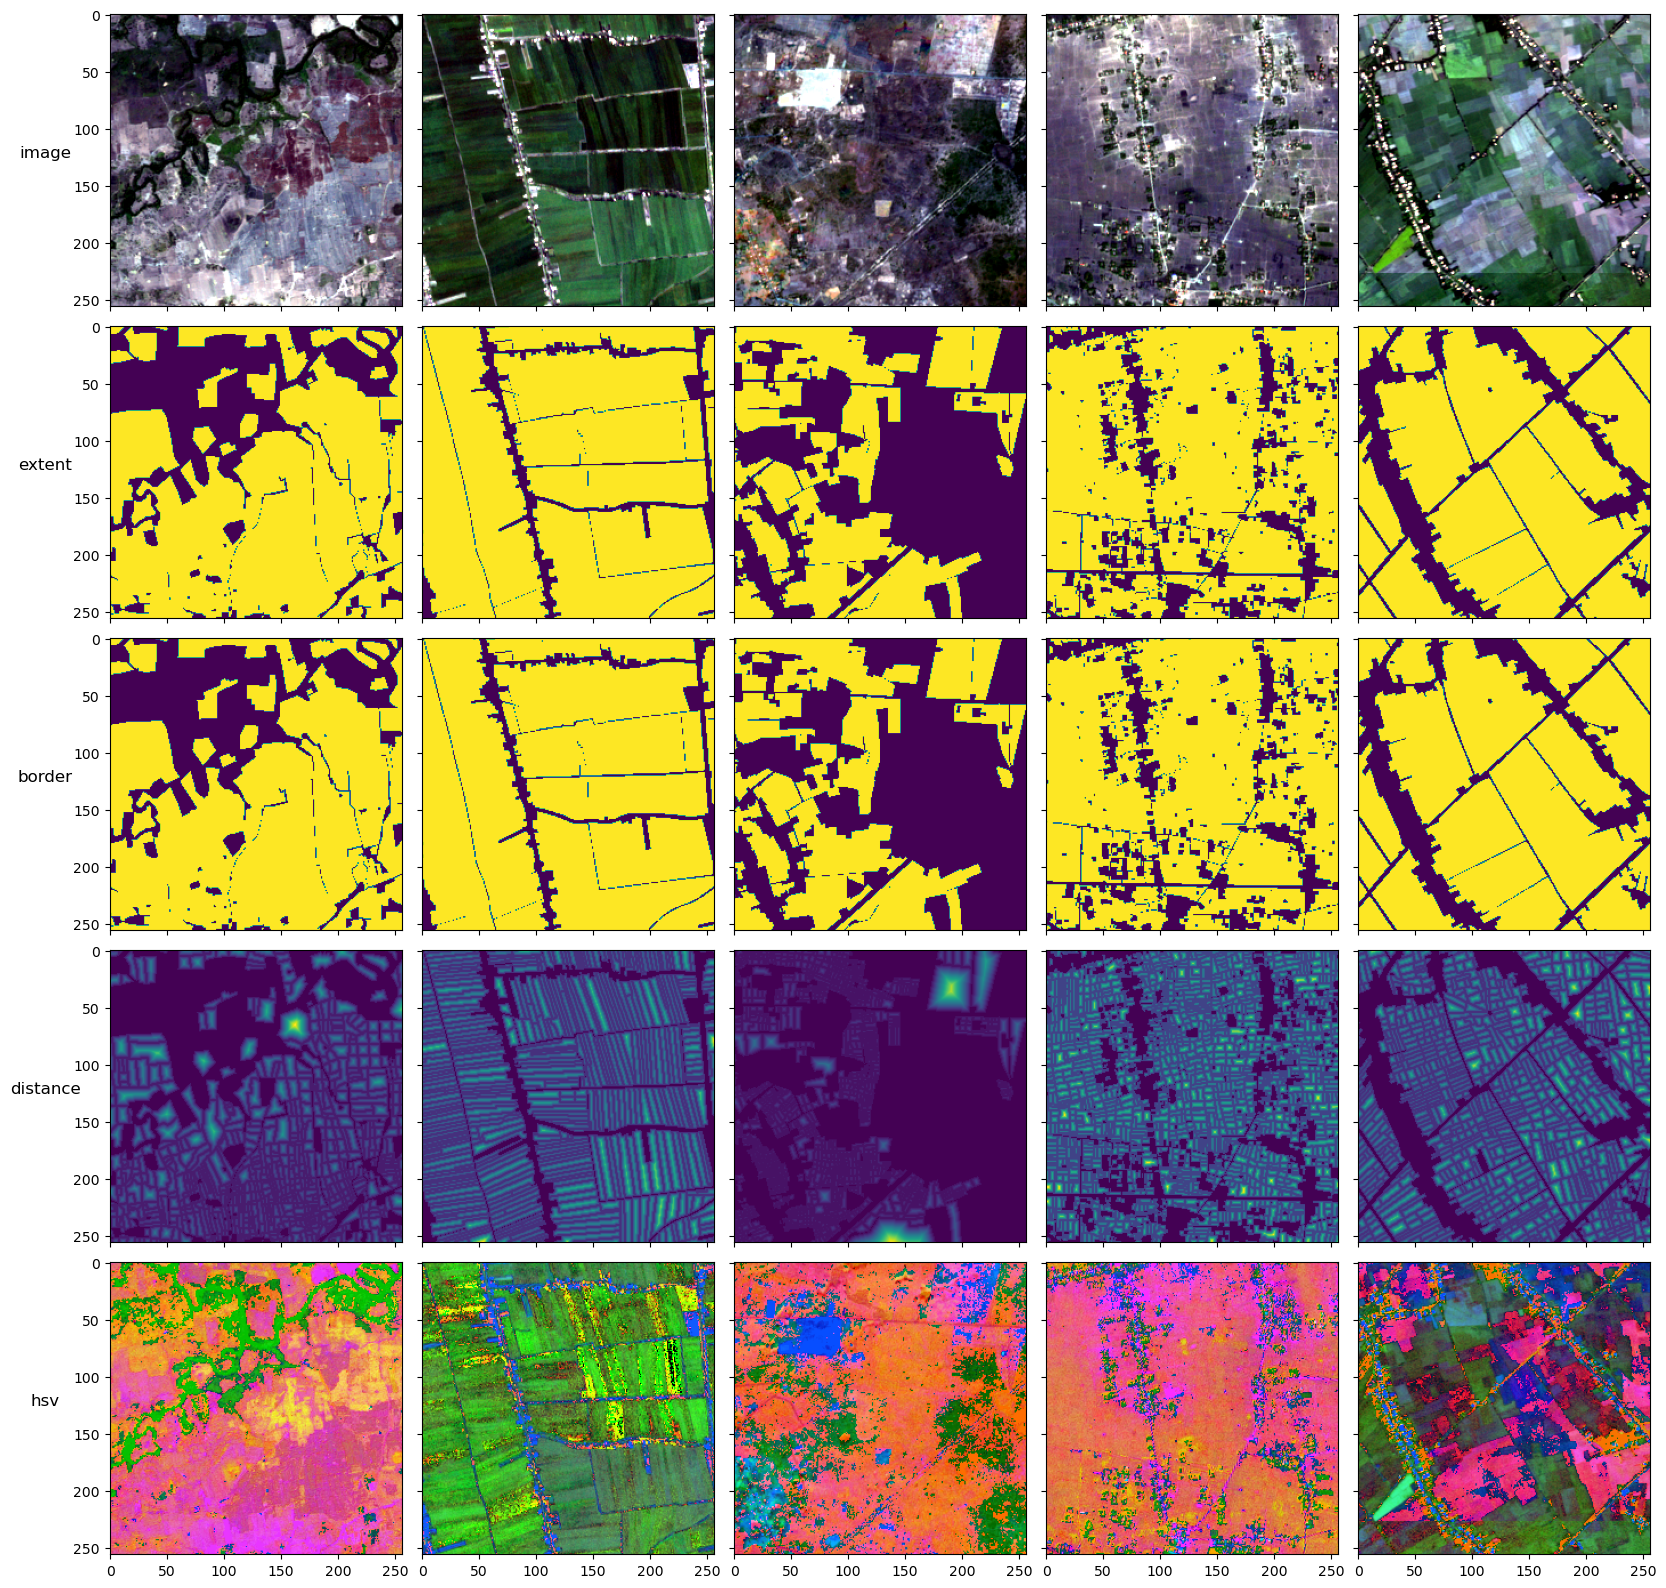

In [ ]:
train_dataset, valid_dataset, test_dataset = get_datasets(paths['image'], 
                                                    paths['mask'],
                                                    paths['distance'], 
                                                    extent_band,
                                                    border_band,
                                                    distance_band,
                                                    min_max, 
                                                    data_augmentations)

train_dataloader, valid_dataloader, test_dataloader = get_loaders(train_dataset, 
                                                                valid_dataset, 
                                                                test_dataset, 
                                                                batch_size, 
                                                                n_cpu)

show_samples(train_dataloader, labels=labels, nb_samples = 5)


## Training

In [ ]:
net = ResUnet(num_classes=2)
model = AdamWMultiStep(net, loss, lr)
callbacks = get_callbacks()

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
model, trainer, logger = training_loop(model, 
                                       train_dataloader, 
                                       valid_dataloader, 
                                       project_name, 
                                       max_epochs, 
                                       hyperparameters, 
                                       callbacks)

model = AdamWMultiStep.load_from_checkpoint(callbacks[1].best_model_path, model=net, loss=loss, lr=lr)
validate_test(model, trainer, valid_dataloader, test_dataloader)
send_images(model, logger, test_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quentin-yeche (quentin-yeche-phd). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name  | Type    | Params
----------------------------------
0 | model | ResUnet | 0     
----------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'loss': 1.971207857131958,
  'valid_border_f1_score': 0.6666666865348816,
  'valid_border_iou': 0.5,
  'valid_extent_f1_score': 0.40851306915283203,
  'valid_extent_iou': 0.25668638944625854}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'loss': 1.8994040489196777,
  'test_border_f1_score': 0.6666658520698547,
  'test_border_iou': 0.4999990463256836,
  'test_extent_f1_score': 0.3981952965259552,
  'test_extent_iou': 0.24859167635440826}]


KeyError: 0